# TOP


In [ ]:
import numpy as np
import cv2
import os
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras.losses import categorical_crossentropy
from keras.models import Sequential
# from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import models
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers import Dropout, Input
from keras.layers import Flatten, add
from keras.layers import Dense, LSTM, TimeDistributed, ConvLSTM2D 
from keras.layers.normalization import BatchNormalization  # batch Normalization for managing internal covariant shift.
from keras.layers import Activation
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import time

from tqdm import tqdm

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Unzip the dataset and copy Learning Rate Finder file and Cyclical Learning Rate callback file

In [ ]:
!cp "/content/gdrive/My Drive/learningratefinder.py" .
!cp "/content/gdrive/My Drive/clr_callback.py" .

In [ ]:
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR

In [ ]:
!unzip "/content/gdrive/My Drive/dataASL3.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataASL3/val/P/P746.jpg  
  inflating: dataASL3/val/P/P747.jpg  
  inflating: dataASL3/val/P/P757.jpg  
  inflating: dataASL3/val/P/P765.jpg  
  inflating: dataASL3/val/P/P777.jpg  
  inflating: dataASL3/val/P/P780.jpg  
  inflating: dataASL3/val/P/P781.jpg  
  inflating: dataASL3/val/P/P783.jpg  
  inflating: dataASL3/val/P/P789.jpg  
  inflating: dataASL3/val/P/P79.jpg  
  inflating: dataASL3/val/P/P791.jpg  
  inflating: dataASL3/val/P/P795.jpg  
  inflating: dataASL3/val/P/P801.jpg  
  inflating: dataASL3/val/P/P803.jpg  
  inflating: dataASL3/val/P/P805.jpg  
  inflating: dataASL3/val/P/P809.jpg  
  inflating: dataASL3/val/P/P813.jpg  
  inflating: dataASL3/val/P/P814.jpg  
  inflating: dataASL3/val/P/P834.jpg  
  inflating: dataASL3/val/P/P84.jpg  
  inflating: dataASL3/val/P/P85.jpg  
  inflating: dataASL3/val/P/P867.jpg  
  inflating: dataASL3/val/P/P88.jpg  
  inflating: dataASL3/val/P/P885.jpg  
  inflating: data

# Hyperparameters-Augmentation-Load Dataset Using Generator

In [ ]:
nclass = 29
path = 'dataASL3/'
# path = 'temp/'
output = '/content/gdrive/My Drive/TA/output'
train_path = path + 'train'
val_path = path + 'val'
test_path = path + 'test'
IMAGE_SIZE = 112
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 30
BATCH_SIZE = 64

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)


In [ ]:
# Data augmentation
training_data_generator = ImageDataGenerator(
    # rotation_range=500,
    rescale=1./255,
    # shear_range=0.1,
    # zoom_range=0.2,
    horizontal_flip=True,
		fill_mode="nearest"
        )

validation_data_generator = ImageDataGenerator(
    # rotation_range=500,
    rescale=1./255,
    # shear_range=0.1,
    # zoom_range=0.2,
    horizontal_flip=True,
		fill_mode="nearest"
        )
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
training_generator = training_data_generator.flow_from_directory(
    train_path,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    val_path,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="categorical", 
    shuffle=False)

Found 60900 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.
Found 60900 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.


# Make Model

## Try EfficientNet B4

In [ ]:
#model for rgb input
from tensorflow.keras.applications import EfficientNetB4
global modell
modell = EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape = input_shape,
    input_tensor=None,
    pooling= 'avg')


In [ ]:
modell.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 112, 112, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 112, 112, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 113, 113, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

# Make FC layers

In [ ]:
#add FC layers for rgb model

from keras.layers import GlobalAveragePooling2D
import keras
x = Dense(512, activation='relu')(modell.layers[-1].output)
x = Dropout(0.5)(x)
x = Dense(96,activation='relu')(x)
x = Dense(29, activation='softmax')(x)
model2 = Model(inputs=modell.input, outputs=x)
learningRate=0.1
# decay=learningRate/epochs
sgd = SGD(lr=learningRate, momentum=0.9, nesterov=False)
model2.compile(loss=categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 112, 112, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 112, 112, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 113, 113, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.618572 to fit



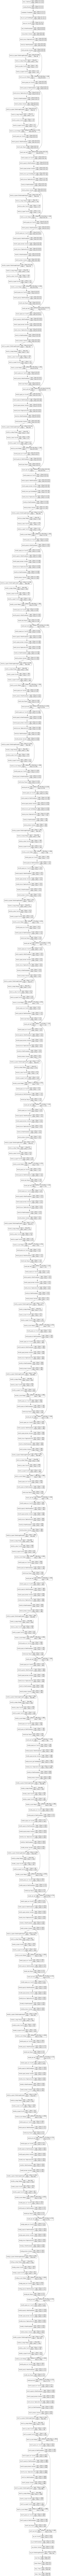

In [ ]:
plot_model(model2, show_shapes=True)
# to_file='/content/gdrive/My Drive/TA/model16102020.png'

# Find the optimum **Learning Rate**

[INFO] finding learning rate...
Epoch 1/3
951/951 [==============================] - 386s 406ms/step - loss: 3.4690 - accuracy: 0.0321
Epoch 2/3
951/951 [==============================] - 387s 407ms/step - loss: 3.4676 - accuracy: 0.0344
Epoch 3/3
951/951 [==============================] - 386s 406ms/step - loss: 2.1631 - accuracy: 0.3955
[INFO] learning rate finder complete


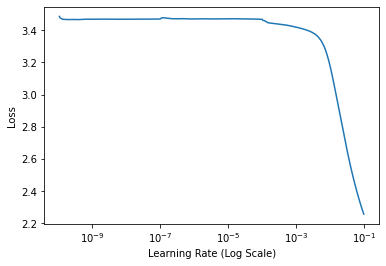

In [ ]:
#RGB
print("[INFO] finding learning rate...")
lr = LearningRateFinder(model2)
lr.find(training_generator, 1e-10, 0.1,
		stepsPerEpoch=60900//64, batchSize = 64)

lr.plot_loss()

print("[INFO] learning rate finder complete")

# Re-Compile after find optimum LR, if current LR isn't optimum LR

In [ ]:
epochs=20
learningRate=0.1
# decay=learningRate/epochs

sgd = SGD(lr=learningRate, momentum=0.9, nesterov=False)
model2.compile(loss=categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])
model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 112, 112, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 112, 112, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 113, 113, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

# Training

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import EarlyStopping

# every 10 epochs save weights
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/TA/weights.{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',monitor='val_acc',
                              verbose=1,save_best_only=False,save_weights_only=True,mode='auto',
                              period = 10)
#every epoch check validation accuracy scores and save the highest
checkpoint_2 = ModelCheckpoint('/content/gdrive/My Drive/TA/best112notAtAll.{epoch:02d}-{val_loss:.4f}-{val_accuracy:.4f}.hdf5',monitor='val_accuracy',
                              verbose=1,save_best_only=True,save_weights_only=True,mode='auto',
                              period = 1)
# model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
# use tensorboard can watch the change in time
tensorboard_ = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0,
                          embeddings_layer_names=None, embeddings_metadata=None)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
#The training will stop if the validation loss does not decrease for 3 epochs.
start = time.time()
history = model2.fit_generator(training_generator,  verbose=1,steps_per_epoch =60900//64,
                    epochs=30,validation_data = validation_generator,validation_steps=13050//64,callbacks = [tensorboard_, checkpoint_2])
end = time.time()
print('Time : {} s'.format(end-start))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
  1/951 [..............................] - ETA: 0s - loss: 3.5116 - accuracy: 0.0156WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
951/951 [==============================] - ETA: 0s - loss: 0.3827 - accuracy: 0.8913
Epoch 00001: val_accuracy improved from -inf to 0.03618, saving model to /content/gdrive/My Drive/TA/best112notAtAll.01-13.5216-0.0362.hdf5
951/951 [==============================] - 422s 443ms/step - loss: 0.3827 - accuracy: 0.8913 - val_loss: 13.5216 - val_accuracy: 0.0362
Epoch 2/30
951/951 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9916
Epoch 00002: val_accuracy did not improve from 0.03618
951/951 [==============================

# Visualize the performance of the model during training

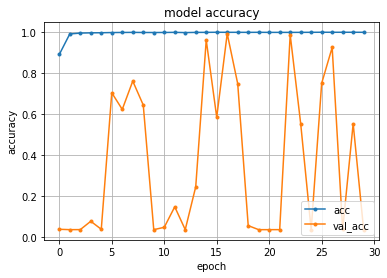

In [ ]:
#with dropout(0.5) and regularizers L2 0.001    100 epocs
plt.plot(history.history['accuracy'], marker='.')
plt.plot(history.history['val_accuracy'], marker='.')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

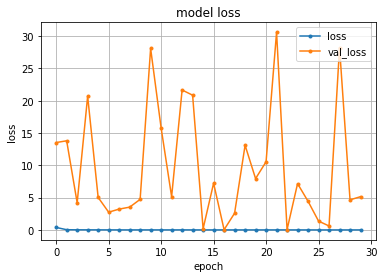

In [ ]:
#with dropout(0.5) and regularizers L2 0.001    100 epocs
plt.plot(history.history['loss'], marker='.')
plt.plot(history.history['val_loss'], marker='.')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

# Test the model

In [ ]:
model2.load_weights('/content/gdrive/My Drive/TA/best112notAtAll.17-0.0334-0.9931.hdf5')

In [ ]:
test_evaluate = model2.evaluate_generator(generator = test_generator, steps=13050, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
13050/13050 [==============================] - 214s 16ms/step - loss: 0.1874 - accuracy: 0.9625


In [ ]:
pred=model2.predict_generator(test_generator,
verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
13050/13050 [==============================] - 193s 15ms/step


In [ ]:
y_pred = []
for i in range(len(pred)):
  y_pred.append(np.argmax(pred[i]))
# y_pred

from sklearn.metrics import confusion_matrix
cf_matrix =confusion_matrix(np.array(y_pred), test_generator.classes) 
np.matrix(cf_matrix)


matrix([[432,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   1,   3,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [  1, 450,   0,   0,   9,   0,   0,   0,   6,   0,   0,   0,   6,
           0,   0,   0,   0,   3,   0,   0,  28,   2,   2,   0,   0,   0,
           0,   0,   0],
        [  0,   0, 450,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [  0,   0,   0, 450,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [  0,   0,   0,   0, 433,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [  0,   0,   0,   0,   0, 450,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
def getList(dict): 
    return dict.keys() 
      
head = getList(training_generator.class_indices)
head = list(head)
import pandas as pd
datacm = pd.DataFrame(cf_matrix)
datacm.to_csv('/content/gdrive/My Drive/TA/CM_112notAll.csv', header = head, index=False, sep = ';')

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_generator.classes, np.array(y_pred)))

0.9625287356321839


In [ ]:
from sklearn.metrics import precision_score
print(precision_score(test_generator.classes, np.array(y_pred), average='macro'))

0.9682942431236378


In [ ]:
from sklearn.metrics import recall_score
print(recall_score(test_generator.classes, np.array(y_pred), average='macro'))

0.9625287356321839


In [ ]:
from sklearn.metrics import f1_score
print(f1_score(test_generator.classes, np.array(y_pred), average='macro'))

0.96344245597704


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes, np.array(y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       450
           1       0.89      1.00      0.94       450
           2       1.00      1.00      1.00       450
           3       1.00      1.00      1.00       450
           4       1.00      0.96      0.98       450
           5       1.00      1.00      1.00       450
           6       0.98      0.98      0.98       450
           7       0.95      0.99      0.97       450
           8       0.88      0.97      0.92       450
           9       0.93      0.99      0.96       450
          10       0.88      1.00      0.94       450
          11       0.99      0.99      0.99       450
          12       0.99      0.93      0.96       450
          13       0.96      0.96      0.96       450
          14       1.00      1.00      1.00       450
          15       0.99      1.00      0.99       450
          16       0.99      0.98      0.98       450
          17       0.99    

# Time Evaluation for predict 1 data

In [ ]:
test_generator.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

10


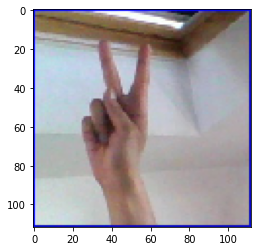

In [ ]:
plt.imshow(test_generator[4645][0][0])
print(np.argmax(test_generator[4645][1][0]))

In [ ]:
start = time.time()
predtest = model2.predict_generator(test_generator[4645][0][0])
end = time.time()
print(end-start)

0.11216545104980469


In [ ]:
model2.save("/content/gdrive/My Drive/TA/model112notCLR.h5")

**-----------------------------------------------------------END---------------------------------------------------------------------------------------------**